In [1]:
import random

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class DataProcessor():
    def __init__(self, path):
        self.data_df = pd.read_csv(path)  # 加载数据

    # EDA
    def eda(self, opt):
        assert opt in ['view_data', 'count_class_distri', 'text_length_distri'], 'opt is wrong'
        if opt == 'view_data':  # 查看数据前几行
            self._view_data()
        elif opt == 'count_class_distri':  # 查看类别标签的分布情况:0蕴含，1不相干，2矛盾
            self._count_class_distri()
        elif opt == 'text_length_distri':  # 查看文本长度的分布情况
            self._text_length_distri()

    # 获取数据封装(训练和开发认证)
    def get_dataloader(self):
        data_list = self.data_df[['premise', 'hypothesis', 'label']].values.tolist()
        random.shuffle(data_list)
        k = len(data_list) // 5

        train_dataset = MyDataset(data_list[k:])
        train_dataloader = DataLoader(train_dataset, batch_size=8)
        dev_dataset = MyDataset(data_list[:k])
        dev_dataloader = DataLoader(dev_dataset, batch_size=16)
        return train_dataloader, dev_dataloader

    def _view_data(self):  # "_"表示供EDA调用的辅助方法
        print(self.data_df.head())

    # 统计不同label有多少个，绘图表示
    def _count_class_distri(self):
        plt.figure(figsize=(6, 4))
        sns.countplot(data=self.data_df, x='label')
        plt.title('Class Distribution')
        plt.xlabel('Class')
        plt.ylabel('Count')
        plt.show()

    def _text_length_distri(self):
        self.data_df['premise_length'] = self.data_df['premise'].apply(lambda x: len(x.split()))
        self.data_df['hypothesis_length'] = self.data_df['hypothesis'].apply(lambda x: len(x.split()))

        # 创建一个带有子图的画布
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

        # 在第一个子图中绘制premise的箱型图
        sns.boxplot(data=self.data_df, y='premise_length', ax=axes[0])
        axes[0].set_title('Premise Length Distribution')
        axes[0].set_ylabel('Length')

        # 在第二个子图中绘制hypothesis的箱型图
        sns.boxplot(data=self.data_df, y='hypothesis_length', ax=axes[1])
        axes[1].set_title('Hypothesis Length Distribution')
        axes[1].set_ylabel('Length')

        # 调整子图间距
        plt.tight_layout()
        plt.show()

           id                                            premise  \
0  5130fd2cb5  and these comments were considered in formulat...   
1  5b72532a0b  These are issues that we wrestle with in pract...   
2  3931fbe82a  Des petites choses comme celles-là font une di...   
3  5622f0c60b  you know they can't really defend themselves l...   
4  86aaa48b45  ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...   

                                          hypothesis lang_abv language  label  
0  The rules developed in the interim were put to...       en  English      0  
1  Practice groups are not permitted to work on t...       en  English      2  
2              J'essayais d'accomplir quelque chose.       fr   French      0  
3  They can't defend themselves because of their ...       en  English      0  
4    เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร       th     Thai      1  


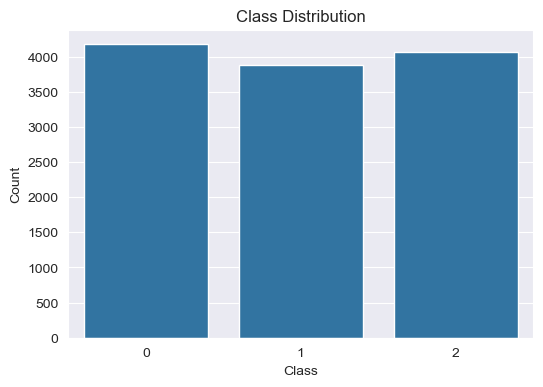

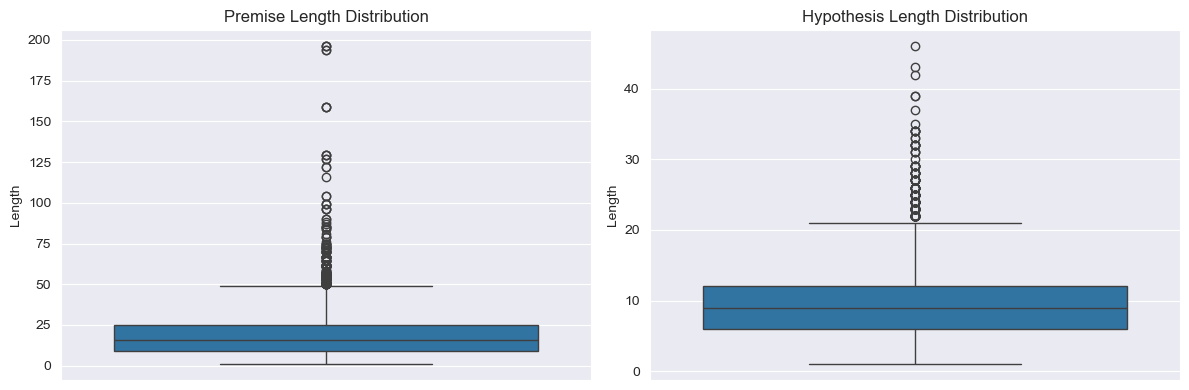

OSError: Can't load tokenizer for 'D:\AIClass_demo\AIClass_demo0\single_work\BERT'. If you were trying to load it from 'https://huggingface.co/models', make sure you don't have a local directory with the same name. Otherwise, make sure 'D:\AIClass_demo\AIClass_demo0\single_work\BERT' is the correct path to a directory containing all relevant files for a BertTokenizerFast tokenizer.

In [42]:
import os

os.environ['HF_ENDPOINT'] = 'https://hf-mirror.com'

processor = DataProcessor('data/train.csv')
processor.eda('view_data')
processor.eda('count_class_distri')
processor.eda('text_length_distri')
train_dataloader, dev_dataloader = processor.get_dataloader()

# for batch in train_dataloader:
#     print(batch['input_ids'].shape)  # [8,128],[batch_size,max_length]
#     print(batch['attention_mask'].shape)  # [8,128]
#     print(batch['label'].shape)  # [8]
#     break


In [40]:
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer
import os

model_name = 'D:\\AIClass_demo\\AIClass_demo0\\single_work\\BERT'
model_name = model_name.to(device)
# cache_dir = r'C:\Users\a1824\.cache\huggingface\hub\models--bert-base-uncased'

# 覆写torch.utils.data下的Dataset类，必不可少
class MyDataset(Dataset):
    # 数据封装，出去的满足神经网络训练的张量形式
    def __init__(self, data_list):  # data_list = [[premise, hypothesis, label],[]...]
        self.data = data_list
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        premise = self.data[idx][0]
        hypothesis = self.data[idx][1]
        label = self.data[idx][2]

        encoding = self.tokenizer(premise, hypothesis,
                                  add_special_tokens=True,  # 会在两个句子之间加一个特殊token
                                  max_length=128,
                                  padding='max_length',
                                  truncation=True,
                                  return_tensors='pt')
        input_ids = encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'].squeeze()
        label = torch.tensor(label, dtype=torch.long)

        return {'input_ids': input_ids,
                'attention_mask': attention_mask,
                'label': label}


In [43]:
from transformers import AutoModelForSequenceClassification
from torch.optim import AdamW

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

optimizer = AdamW(model.parameters(), lr=2e-5)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at D:\AIClass_demo\AIClass_demo0\single_work\BERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import torch

# 设置训练轮次
epochs = 3
for epoch in range(epochs):
    model.train()  # 设置模型为训练模式
    total_loss = 0
    for batch in train_dataloader:
        optimizer.zero_grad()  # 清除上一轮的梯度

        # 获取批次数据
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        # 前向传播
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        # 反向传播
        loss.backward()
        optimizer.step()  # 更新模型参数

    print(f'Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(train_dataloader)}')

Epoch 1/3, Loss: 1.0419634226771077


In [ ]:
# 假设你有一个验证集的 DataLoader（val_dataloader）
model.eval()  # 设置模型为评估模式
correct_predictions = 0
total_predictions = 0
with torch.no_grad():
    for batch in dev_dataloader:  # 验证集的数据
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        predictions = torch.argmax(logits, dim=-1)
        correct_predictions += (predictions == labels).sum().item()
        total_predictions += labels.size(0)

accuracy = correct_predictions / total_predictions
print(f'Validation Accuracy: {accuracy}')


In [ ]:
test_data = pd.read_csv('data/test.csv')

test_list = test_data[['premise','hypothesis']].value.tolist()

test_dataset = MyDataset(test_list)
test_dataloader = DataLoader(test_dataset,batch_size=16)

model.eval()
predictions = []


with torch.no_grad():  # 禁用梯度计算
    for batch in test_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        # 预测
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1).cpu().numpy()

        predictions.extend(preds)

# 创建与上传的格式一致的结果 DataFrame
submission_df = pd.DataFrame({
    'id': test_data['id'],  # 使用测试数据的 id 列
    'prediction': predictions
})

# 保存结果为新的 CSV 文件
submission_df.to_csv('submission.csv', index=False)